In [3]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import gsw_xarray as gsw
from cmocean import cm as cmo  
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
file_path = 'C:/Users/emmfr/Fysisk oceanografi/OC4920/PROJECT/Data/adcp_data_6_maj.txt'

# Read the data, skipping the header lines and using space as a delimiter
df = pd.read_csv(file_path, skiprows=12, sep='\t')
df.columns


Index(['Ens', 'YR', 'MO', 'DA', 'HH', 'MM', 'SS', 'HH.1', 'Unnamed: 8', 'Pit',
       'Rol', 'Hea', 'Eas', 'Eas.1', 'Eas.2', 'Eas.3', 'Eas.4', 'Eas.5',
       'Eas.6', 'Eas.7', 'Eas.8', 'Eas.9', 'Nor', 'Nor.1', 'Nor.2', 'Nor.3',
       'Nor.4', 'Nor.5', 'Nor.6', 'Nor.7', 'Nor.8', 'Nor.9', '    "FLat"',
       '    "FLon"', '    "LLat"', '    "LLon"'],
      dtype='object')

In [22]:
df = pd.read_csv(file_path, sep="\t", skiprows=12)   # or sep='\s+' if it’s whitespace‑delimited
print(df.head())
print(df.columns.tolist())

   Ens    YR   MO   DA    HH    MM    SS  HH.1  Unnamed: 8    Pit  ... Nor.4  \
0  NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN         NaN    deg  ...  mm/s   
1  NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN         NaN    NaN  ...     5   
2  1.0  25.0  5.0  6.0   9.0  52.0  43.0   1.0         NaN  -0,06  ...   NaN   
3  2.0  25.0  5.0  6.0   9.0  57.0  45.0   4.0         NaN  -0,22  ...   NaN   
4  3.0  25.0  5.0  6.0  10.0   2.0  46.0   7.0         NaN  -0,25  ...   NaN   

  Nor.5 Nor.6 Nor.7 Nor.8 Nor.9       "FLat"       "FLon"       "LLat"  \
0  mm/s  mm/s  mm/s  mm/s  mm/s        "deg"        "deg"        "deg"   
1     6     7     8     9    10          NaN          NaN          NaN   
2   NaN   NaN   NaN   NaN   NaN  57,63881338  11,69352623  57,64167345   
3   NaN   NaN   NaN   NaN   NaN  57,64177588  11,70030819  57,64738966   
4   NaN   NaN   NaN   NaN   NaN  57,64729771  11,67888874  57,63940003   

        "LLon"  
0        "deg"  
1          NaN  
2  11,70028615  
3  11,

In [12]:
east = (df[['Eas', 'Eas.1', 'Eas.2', 'Eas.3', 'Eas.4', 'Eas.5',
       'Eas.6', 'Eas.7', 'Eas.8','Eas.9']].iloc[2:].astype(float).to_numpy())

t = [datetime.datetime(2000+df["YR"][i+2].astype(int),
                    df["MO"][i+2].astype(int),
                    df["DA"][i+2].astype(int),
                    df["HH"][i+2].astype(int),
                    df["MM"][i+2].astype(int),
                    df["SS"][i+2].astype(int)) for i in range(len(df)-2)]

depth = np.array([8+i*4 for i in range(10)])

east_da = xr.DataArray(
    east,
    dims=["time", "depth"],
    coords={"time": t, "depth": depth},
    name="east_velocity"
)
north = (df[['Nor', 'Nor.1', 'Nor.2', 'Nor.3', 'Nor.4', 'Nor.5',
       'Nor.6', 'Nor.7', 'Nor.8', 'Nor.9']].iloc[2:].astype(float).to_numpy())

t = [datetime.datetime(2000+df["YR"][i+2].astype(int),
                    df["MO"][i+2].astype(int),
                    df["DA"][i+2].astype(int),
                    df["HH"][i+2].astype(int),
                    df["MM"][i+2].astype(int),
                    df["SS"][i+2].astype(int)) for i in range(len(df)-2)]

depth = np.array([8+i*4 for i in range(10)])

north_da = xr.DataArray(
    north,
    dims=["time", "depth"],
    coords={"time": t, "depth": depth},
    name="north_velocity"
)
df['lat'] = np.array([x.replace(',', '.') for x in df["    \"FLat\""].astype(str)])
df['lon'] = np.array([x.replace(',', '.') for x in df["    \"FLon\""].astype(str)])
ds = xr.merge([north_da,east_da,])
ds = ds.where(np.logical_and(np.abs(ds.north_velocity)<500,np.abs(ds.east_velocity)<500))
ds["lat"] = ("time"), df['lat'].values[2:].astype(float)
ds["lon"] = ("time"), df['lon'].values[2:].astype(float)
ds = ds.set_coords("lat")
ds = ds.set_coords("lon")
ds["north_velocity"] = ds["north_velocity"]/1000
ds["east_velocity"] = ds["east_velocity"]/1000

In [13]:
ds = ds.where(ds.time >= np.datetime64('2025-05-07T09:40:00'), drop=True)

In [20]:
ds

<xarray.Dataset> Size: 40B
Dimensions:         (time: 0, depth: 10)
Coordinates:
  * time            (time) datetime64[ns] 0B 
  * depth           (depth) int32 40B 8 12 16 20 24 28 32 36 40 44
    lat             (time) float64 0B 
    lon             (time) float64 0B 
Data variables:
    north_velocity  (time, depth) float64 0B 
    east_velocity   (time, depth) float64 0B

TypeError: No numeric data to plot.

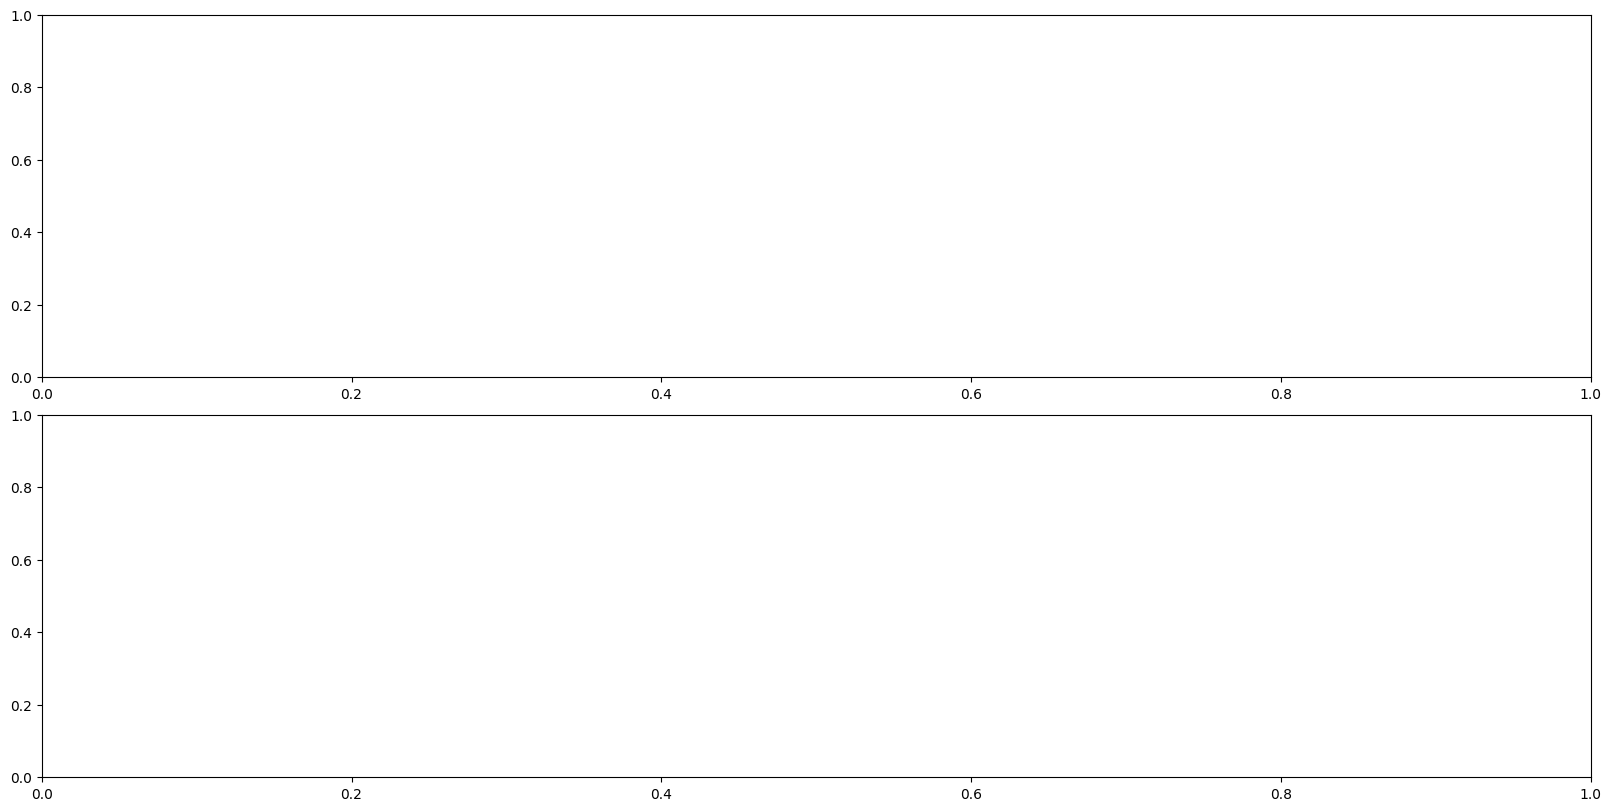

In [15]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].T.plot(ax=ax,cmap=cmo.balance,yincrease=False,vmax=0.25,vmin=-0.25,cbar_kwargs={'label': '{} (m/s)'.format(v)})

TypeError: No numeric data to plot.

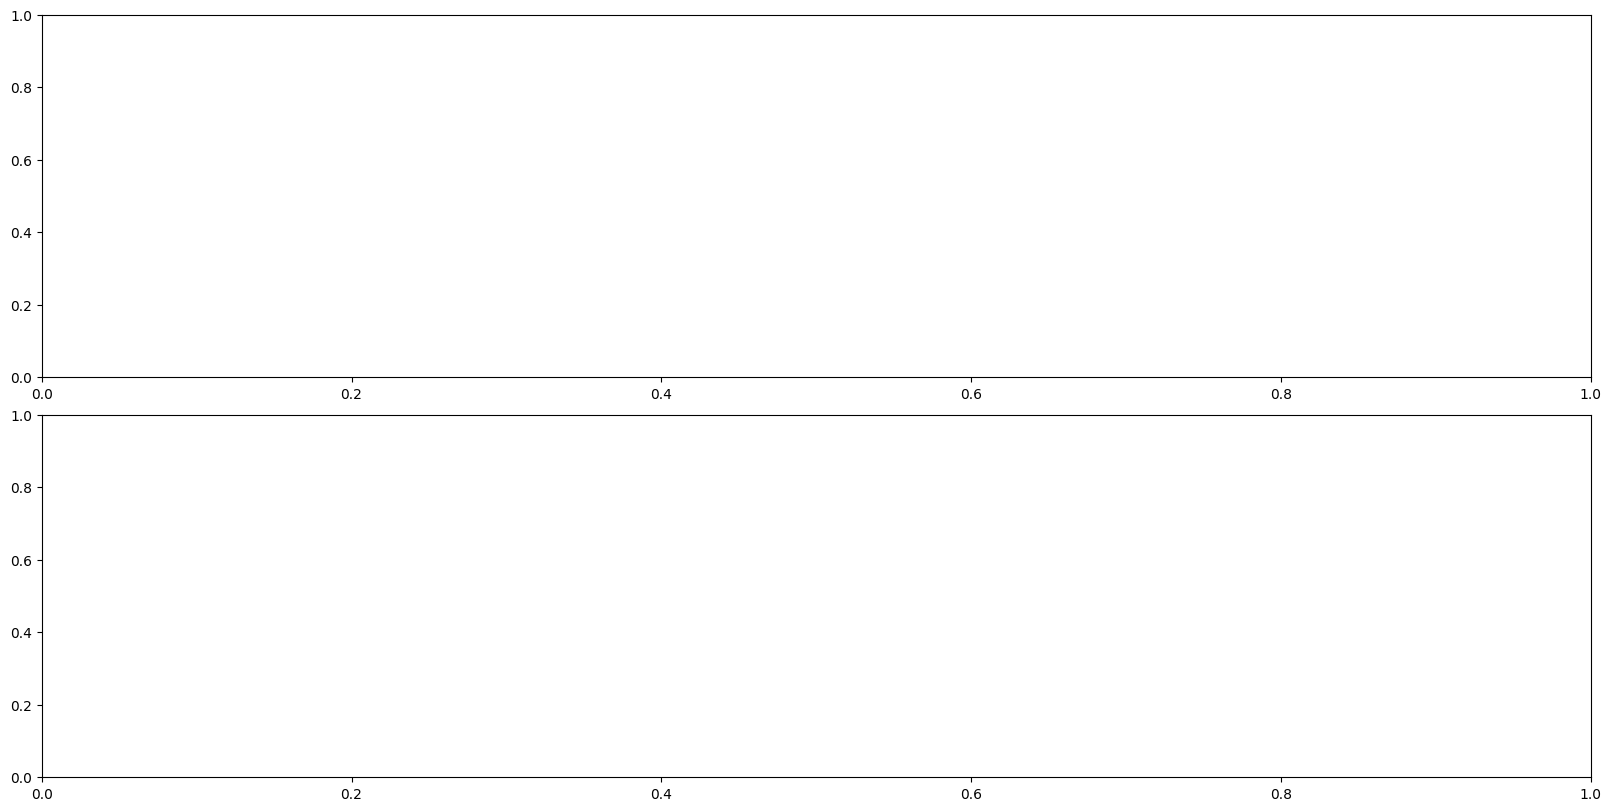

In [19]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].sortby("lat").plot(x="lat",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)


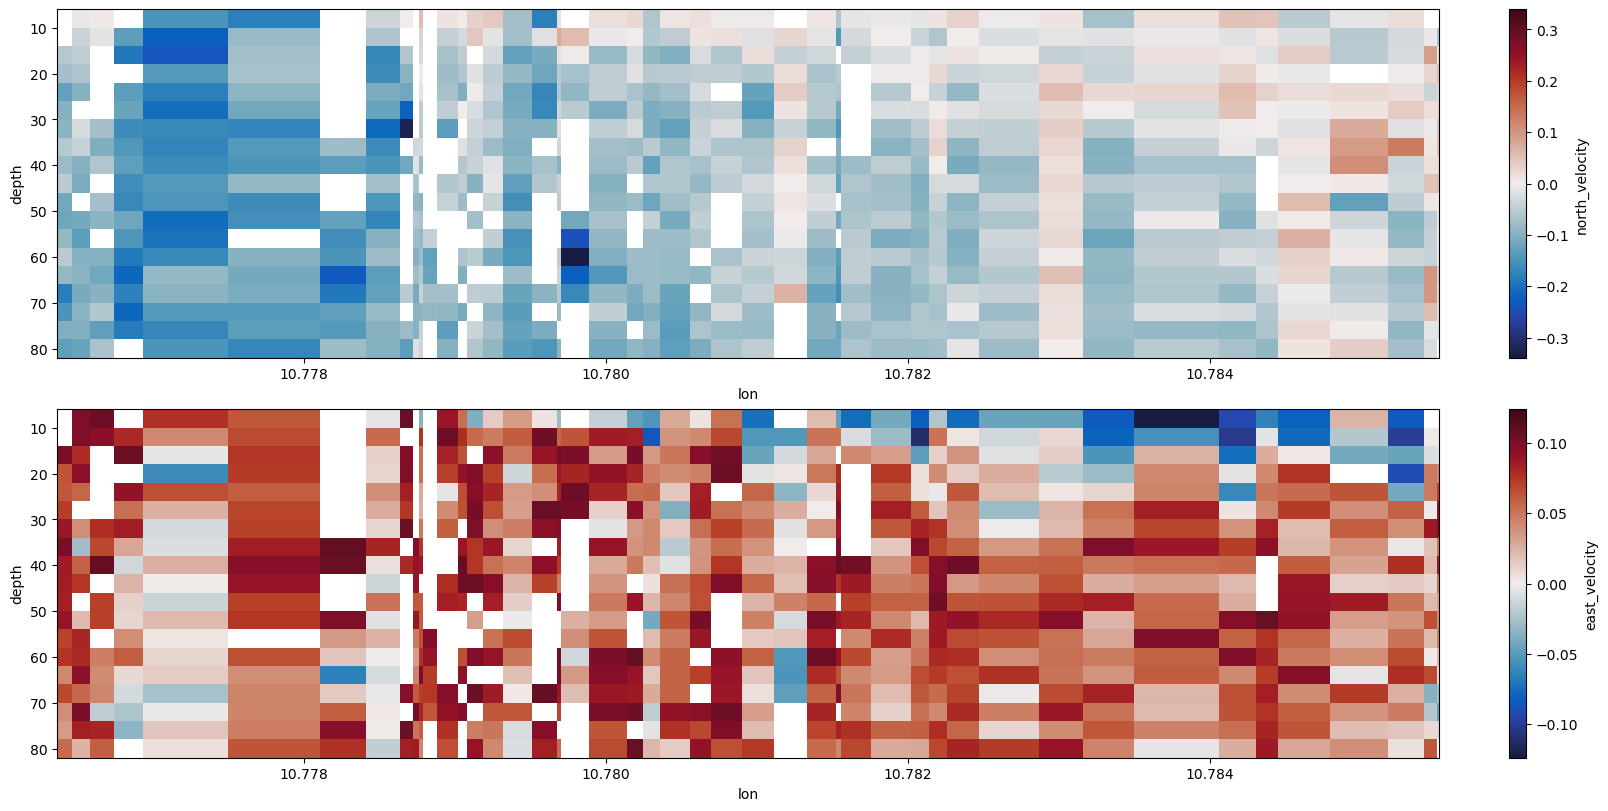

In [158]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].where(ds.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)

In [150]:
ds_test

<xarray.Dataset> Size: 17kB
Dimensions:         (time: 50, depth: 19)
Coordinates:
  * time            (time) datetime64[ns] 400B 2025-05-07T09:40:55 ... 2025-0...
  * depth           (depth) int64 152B 8 12 16 20 24 28 32 ... 60 64 68 72 76 80
    lat             (time) float64 400B 57.76 57.78 57.8 ... 57.85 57.85 57.84
    lon             (time) float64 400B 10.75 10.76 10.77 ... 10.78 10.78 10.78
Data variables:
    north_velocity  (time, depth) float64 8kB nan 0.106 0.018 ... nan nan nan
    east_velocity   (time, depth) float64 8kB nan -0.144 -0.224 ... nan nan nan

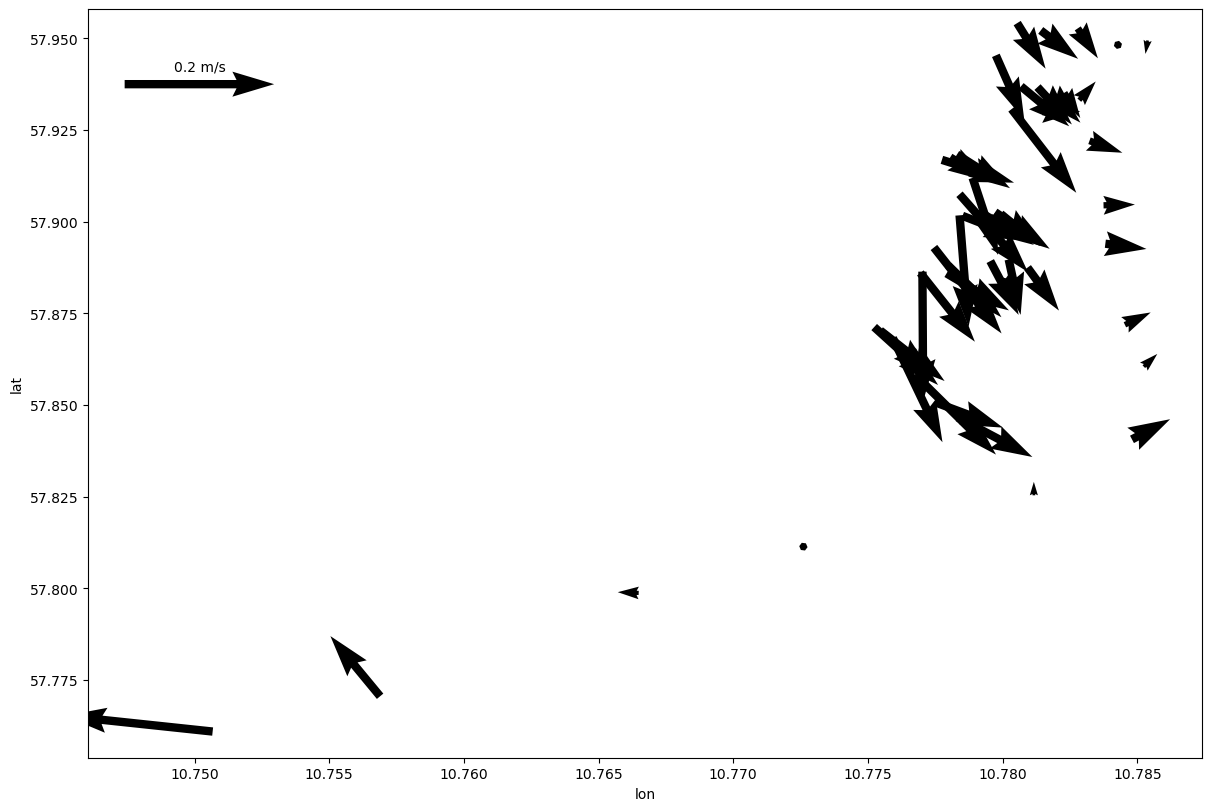

In [157]:
fig,ax = plt.subplots(1,1,figsize=(12,8),constrained_layout=True)

q = ds_test.isel(depth=slice(1,10)).median("depth").plot.quiver(x="lon",
                                                       y="lat",
                                                       u="east_velocity",
                                                       v="north_velocity",
                                                       ax=ax,
                                                       add_guide=False)

ax.quiverkey(q,0.1,0.9,0.2,"0.2 m/s",transform=ax.transAxes)

In [140]:
ds.north_velocity.std()*2

<xarray.DataArray 'north_velocity' ()> Size: 8B
array(0.13593714)

In [143]:
ds_test = ds.where((ds.north_velocity<ds.north_velocity.std()*2)&(ds.east_velocity<ds.east_velocity.std()*2),drop=True)

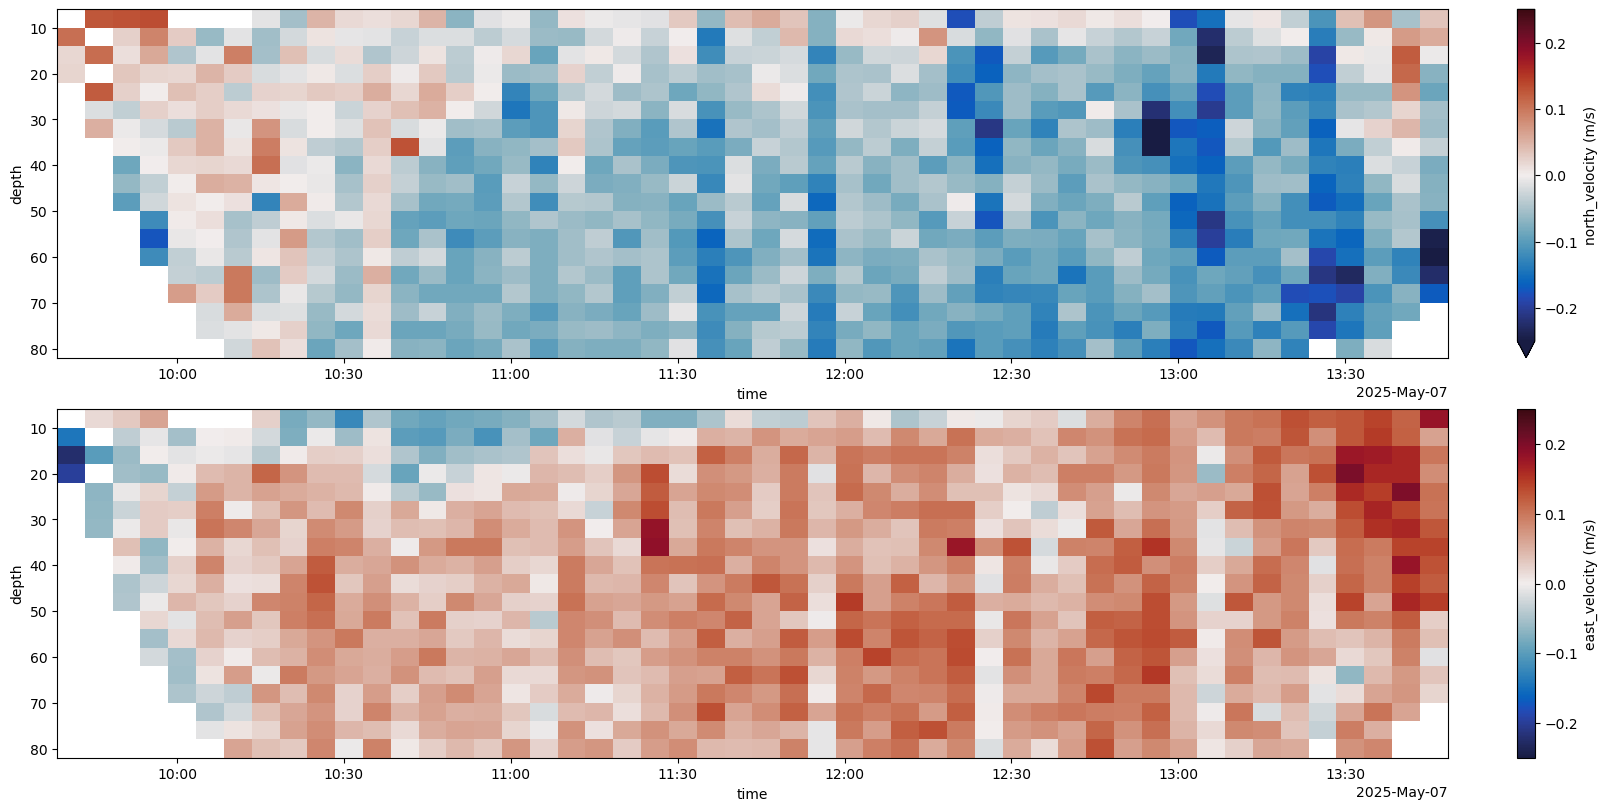

In [135]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].T.plot(ax=ax,cmap=cmo.balance,yincrease=False,vmax=0.25,vmin=-0.25,cbar_kwargs={'label': '{} (m/s)'.format(v)})

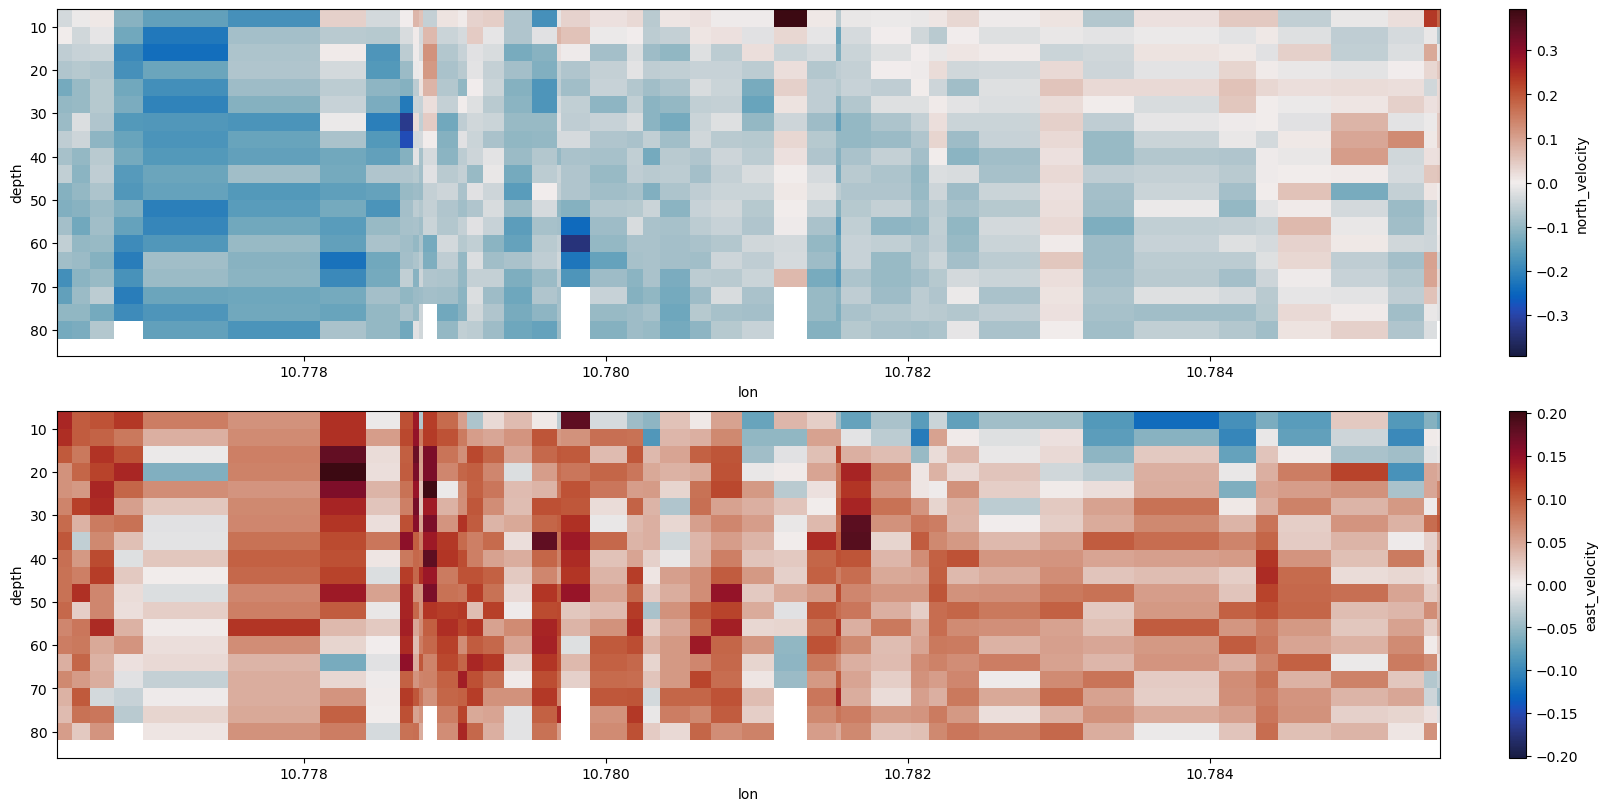

In [136]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].where(ds.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)

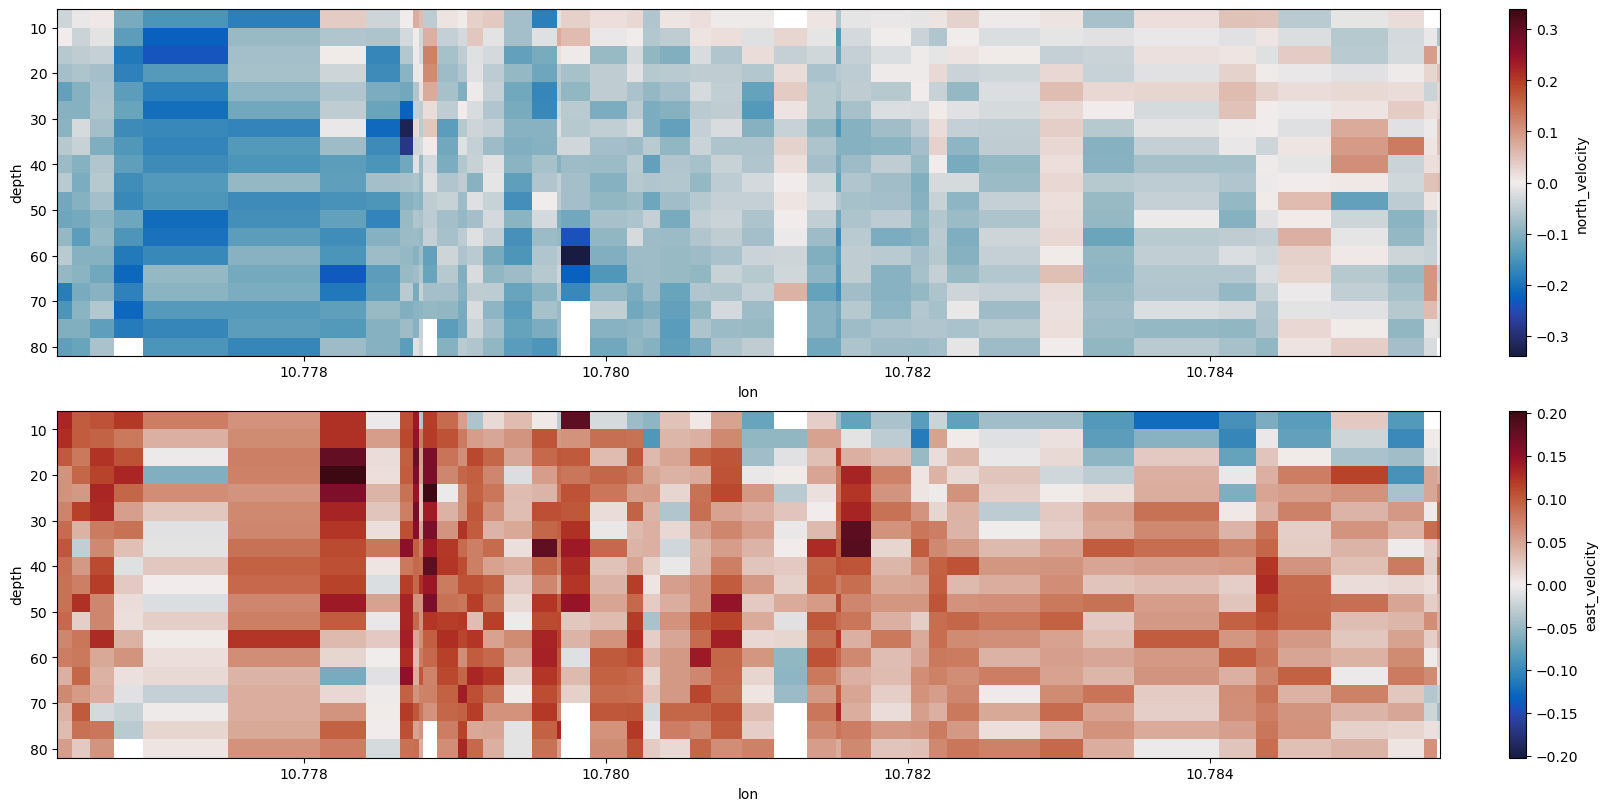

In [137]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].where(ds_test.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)